In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from utils.easy_map import easy_grid_map
import time
from utils.robot_function import detect_frontier, sparse_point_cloud, expand_obstacles
import copy
import scipy.ndimage
from utils.astar import grid_path


class agent:
    def __init__(self,map,init_pose,global_map,node_path = None,dir_use = False) -> None:
        self.map = map
        self.global_map = global_map
        self.pose = init_pose

        #for robot exploration
        self.total_frontier = np.array([],dtype=int).reshape(-1,2)

        self.info_gain_range = 10
        self.h_rad = 10
        self.h_gain = 2

        self.lambda_param = 0.1

    def choose_goal(self):   
        frontier_poses = self.total_frontier   
        if len(frontier_poses) == 0:
            print("no frontier")
            return self.pose

        dis_frontier_poses = np.sqrt(np.sum(np.square(frontier_poses - np.array(self.pose)), axis=1))
        dis_cost = np.abs(dis_frontier_poses - 2)
        
        frontier_info_gain = self.obtain_information_gain(frontier_poses)
        frontier_info_gain[dis_cost < self.h_rad] *= self.h_gain

        value_function = self.lambda_param * frontier_info_gain - dis_cost

        max_index = np.argmax(value_function)

        choose_frontier = copy.deepcopy(frontier_poses[max_index])
        np.delete(self.total_frontier, max_index, axis=0)
        return choose_frontier
    
    def obtain_information_gain(self,frontier):
        #information gain for a certain point
        info_gain_list = []
        for point in frontier:
            local_map = get_local_map(self.map, point, self.info_gain_range)
            info_gain = np.sum(local_map == 100)
            info_gain_list.append(info_gain)
        
        return np.array(info_gain_list)

    def update_frontier(self):
        delete_index = []
        for index, frontier in enumerate(self.total_frontier):
            if self.map[frontier[0],frontier[1]] != 100:
                delete_index.append(index)

        self.total_frontier = np.delete(self.total_frontier, delete_index, axis = 0)

        current_frontier = detect_frontier(self.map) 
        total_frontier = np.vstack((self.total_frontier, current_frontier))
        ds_size = 5
        total_frontier = sparse_point_cloud(total_frontier, ds_size)

        # total_frontier = self.frontier_cluster(total_frontier,cluser_eps = 8,cluster_min_samples = 1).reshape((-1,2))
        self.total_frontier = total_frontier
    
    def navigate_to_point(self,point):
        if self.global_map[point[0], point[1]] != 255:
            print("target in obs, failed in navigation")
            return [self.pose, point]
        now_global_map = self.map
        distance_map = scipy.ndimage.distance_transform_edt(now_global_map != 0) 
        calculate_grid_path = grid_path(now_global_map,distance_map,(self.pose[0],self.pose[1]), [(point[0],point[1])],free_flag=255)
        calculate_grid_path.get_path()

        return calculate_grid_path.foundPath[0]

import time
class sim_env:
    def __init__(self,global_map, init_pose,laser_range,vis = False) -> None:
        #should be 255 free,0 obstacle, 100 unknown

        self.map = global_map #0:free, 255: unknown, 100:obstacle

        self.vis_mask = np.zeros(global_map.shape).astype(bool)
        self.pose = init_pose #[row, col]
        self.pose_list = []
        self.pose_list.append(copy.deepcopy(self.pose))

        self.laser_range = laser_range #int

        self.gen_laser_point()

        self.agent_map = None
        self.vis = vis
    
    def update_pose(self,new_pose):
        self.pose = copy.deepcopy(new_pose)
        if self.vis:
            self.pose_list.append(copy.deepcopy(self.pose))
        
    def gen_laser_point(self,min_angle=0,max_angl=360,resolution=1):
        laser_point = []

        for angle in range(min_angle, max_angl, resolution):
            tmp_point = []
            angle_rad = np.radians(angle)
            x1 = int(self.laser_range * np.cos(angle_rad))
            y1 = int(self.laser_range * np.sin(angle_rad))
            
            #生成点
            distance = max(abs(x1), abs(y1))
            if distance==0:
                return False
            step_x = x1  / distance
            step_y = y1 / distance

            for i in range(int(distance) + 1):
                x = int( i * step_x)
                y = int( i * step_y)
                tmp_point.append((x,y))
            laser_point.append(tmp_point)
        self.laser_point = laser_point
    
    def update_vis(self):
        # for a certain point, update the visiablity
        for laser in self.laser_point:
            for dxdy in laser:
                next_x = self.pose[0] + dxdy[0]
                next_y = self.pose[1] + dxdy[1]
                self.vis_mask[next_x,next_y] = 1
                if self.map[next_x,next_y] != 255: #find not free space in GT map
                    break
    
    def update_agent_map(self):
        #update map for the agent
        self.agent_map = copy.deepcopy(self.map)
        self.agent_map[~self.vis_mask] = 100
    
    def vis_map_points(self,fig,ax, map,points,point_frame = 'uv',scale = 10):
        #point:n*2 array
        #point frame should choose from uv rc
        if point_frame=='uv':
            points = points.reshape((-1,2))
        elif point_frame =='rc':
            points = points.reshape((-1,2))
            points = np.flip(points,axis=1)
        else:
            print("Error point frame")
            return
        ax.axis('equal')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')

        ax.scatter(points[:,0], points[:,1], scale,color='red', marker='o')
        ax.imshow(map, cmap='gray')
        return fig,ax
        

def get_local_map(global_map, next_goal, local_map_size):
    # get local map for a certain point
    # this function will automatically pad the map
    start_x = max(0, next_goal[0] - local_map_size)
    end_x = min(global_map.shape[0], next_goal[0] + local_map_size)
    start_y = max(0, next_goal[1] - local_map_size)
    end_y = min(global_map.shape[1], next_goal[1] + local_map_size)
    
    local_map = np.full((2 * local_map_size, 2 * local_map_size), 100, dtype=np.uint8)
    
    offset_x_start = max(0, local_map_size - next_goal[0])
    offset_x_end = min(2 * local_map_size, global_map.shape[0] - next_goal[0] + local_map_size)
    offset_y_start = max(0, local_map_size - next_goal[1])
    offset_y_end = min(2 * local_map_size, global_map.shape[1] - next_goal[1] + local_map_size)
    
    local_map[offset_x_start:offset_x_end, offset_y_start:offset_y_end] = global_map[start_x:end_x, start_y:end_y]
    
    return local_map




In [2]:
np.random.seed(1)

map_index = 0
exp_index = 0
vis = False
dir_save = False
train_list = []
all_list = []
label_list = []
scene_name_list = []

#start sim exploration
def sim_exp(now_png, now_floor_plan,vis=False):
    local_train_list = []
    local_label_list = []
    local_scene_name_list = []

    input_image = cv2.imread(now_png, cv2.IMREAD_GRAYSCALE)
    input_floor_plan = cv2.imread(now_floor_plan, cv2.IMREAD_GRAYSCALE)

    grid_size = 0.2
    
    easy_map = easy_grid_map(input_image,[0,0],grid_size)
    point = easy_map.random_points_on_map(1)

    now_sim = sim_env(input_image,point[0],12//grid_size,vis) 
    local_map_size = 64 #the size of output map will be 2 * local_map_size x 2 * local_map_size
    
    now_sim.update_vis()
    now_sim.update_agent_map()

    now_agent = agent(now_sim.agent_map,now_sim.pose,now_sim.map)
    now_agent.update_frontier()
    total_step = 1000
    total_time = 0

    for i in range(total_step):
        #find a goal
        next_goal = now_agent.choose_goal()
        #get the path
        now_path = now_agent.navigate_to_point(next_goal)
        if len(now_path) == 0:
            print("failed to find path")
        

        #local map before going to the target point
        global_map = now_sim.agent_map
        local_map_vis = get_local_map(global_map, next_goal, local_map_size)
        # local_map_gt = get_local_map(now_sim.map, next_goal, local_map_size) #gt cluttered map
        local_map_gt = get_local_map(input_floor_plan, next_goal, local_map_size)

        

        local_train_list.append(copy.deepcopy(local_map_vis))
        local_label_list.append(copy.deepcopy(local_map_gt))
        local_scene_name_list.append(copy.deepcopy(now_png))
        
        for next_pose in now_path:
            now_agent.pose = copy.deepcopy([next_pose[0],next_pose[1]])
            now_sim.update_pose([next_pose[0],next_pose[1]])
            now_sim.update_vis()
            
        now_sim.update_agent_map()
        now_agent.map = now_sim.agent_map
        now_agent.update_frontier()

        if len(now_agent.total_frontier) == 0:
            break
    # print(f"step: {i}/{total_step}")
    if vis:
        print(f"step: {i}/{total_step}")
        fig, ax = plt.subplots()
        total_pose_list = np.array(now_sim.pose_list)

        ax.imshow(now_sim.map,cmap='gray')
        #show_mask: show the free space with vis_mask == 1

        show_mask = np.logical_or(now_sim.vis_mask, now_sim.map != 0)
        ax.imshow(show_mask,cmap='gray',alpha=0.5)
        ax.plot(total_pose_list[:,1],total_pose_list[:,0],color=(0.9, 0.9, 0.8))
        ax.axis('equal')
        fig.show()
    
    return local_train_list,local_label_list,local_scene_name_list


In [3]:
import os
from concurrent.futures import ThreadPoolExecutor

def process_file(now_file,vis=False):
    now_png = os.path.join(dataset_path, now_file)
    now_floor_plan = os.path.join(floor_plan_path, now_file)

    local_train_list, local_label_list, local_scene_name_list = sim_exp(now_png,now_floor_plan, vis=vis)
    return local_train_list, local_label_list, local_scene_name_list


train_list = []
label_list = []
scene_name_list = []
num_threads = 24  
repeat_times = 1

vis_flag = False
dataset_path = f"./dataset/cluttered_scene"
floor_plan_path = f"./dataset/floor_plans"
items = os.listdir(dataset_path)

with ThreadPoolExecutor(max_workers=num_threads) as executor:
    futures = [executor.submit(process_file, now_file,vis_flag) for now_file in items for i in range(repeat_times)]
    print("submit all task")
    completed_tasks = 0
    for future in futures:
        completed_tasks += 1
        local_train_list, local_label_list, local_scene_name_list = future.result()

        print(f"Completed tasks: {completed_tasks}")
        

        train_list += local_train_list
        label_list += local_label_list
        scene_name_list += local_scene_name_list

submit all task


In [ ]:
#保存npy文件
if not vis_flag:
    file_name = "dataset/gen_data"
    np.savez(f'./{file_name}/train_list.npz',  train_list = train_list)
    np.savez(f'./{file_name}/label_list.npz',  label_list = label_list)
    np.savez(f'./{file_name}/scene_name_list.npz',  scene_name_list = scene_name_list)
    print(len(train_list), len(label_list))


47282 47282


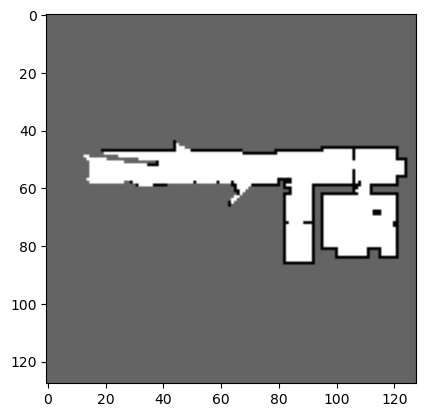

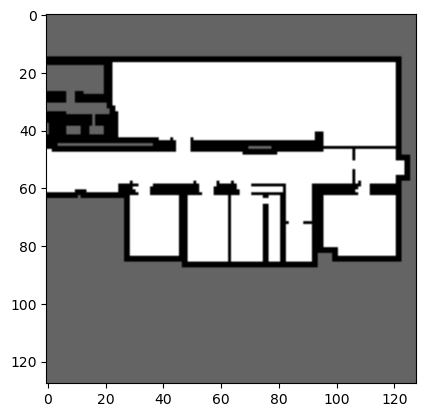

In [ ]:
view_index = 10
plt.imshow(train_list[view_index],cmap="gray")
plt.show()
plt.imshow(label_list[view_index],cmap="gray")
plt.show()
# plt.imshow(all_list[view_index],cmap="gray")
# plt.show()

In [ ]:
file_name = "dataset/gen_data"
scene_name_list = np.load(f'./{file_name}/scene_name_list.npz', allow_pickle=True)["scene_name_list"]

# unique item
unique_file = np.unique(scene_name_list)
print(len(unique_file))

#split train, val, test dataset
from sklearn.model_selection import train_test_split

train_scene_list, test_scene_list = train_test_split(unique_file, test_size=0.3, random_state=42)
val_scene_list, test_scene_list = train_test_split(test_scene_list, test_size=0.5, random_state=42)

print(len(train_scene_list), len(val_scene_list), len(test_scene_list))

140
98 21 21


In [ ]:
train_list = np.load(f'./{file_name}/train_list.npz', allow_pickle=True)["train_list"]
label_list = np.load(f'./{file_name}/label_list.npz', allow_pickle=True)["label_list"]


In [ ]:
train_list_train = []
label_list_train = []

train_list_val = []
label_list_val = []

train_list_test = []
label_list_test = []


for i in range(len(train_list)):
    if scene_name_list[i] in train_scene_list:
        train_list_train.append(train_list[i])
        label_list_train.append(label_list[i])
    elif scene_name_list[i] in val_scene_list:
        train_list_val.append(train_list[i])
        label_list_val.append(label_list[i])
    elif scene_name_list[i] in test_scene_list:
        train_list_test.append(train_list[i])
        label_list_test.append(label_list[i])


np.savez(f'./{file_name}/train_data.npz',  train_list = train_list_train, label_list = label_list_train)
np.savez(f'./{file_name}/val_data.npz',  train_list = train_list_val, label_list = label_list_val)
np.savez(f'./{file_name}/test_data.npz',  train_list = train_list_test, label_list = label_list_test)